#Open Library Analysis - Big Data Computing Project
####Graph's Connected Components vs. k-means Clusters

In this notebook we analyse Open Library's data dumps freely downloadable from their website. https://openlibrary.org/developers/dumps
Books' data is probided in JSON records, which we preprocessed so as to keep only relevant information into a .csv file.

In the following we will clean the dataset and extract relevant features.

We use the resulting dataset to create a graph representing books affinity (i.e. nodes represent books and an edge connects two nodes only if their similarity is above a certain threshold). We are then interested in finding then connected components of such graph. 

Moreover, we will perform k-means clustering and compare, in terms of Silhouette Coefficient, the resulting clusters with the connected components of the aforementioned graph.

##Libraries

In [0]:
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *

from pyspark.sql.functions import *

from pyspark import SparkContext, SparkConf
from time import process_time

In [0]:
spark.sparkContext.setCheckpointDir('/databricks/driver/checkpoints')

##Data Aquisition

In [0]:
%sh wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1qIhBSrpkDc-RCdbw7e1NVtNhOj_fNi5G' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1qIhBSrpkDc-RCdbw7e1NVtNhOj_fNi5G" -O /tmp/books_long.csv.bz2 && rm -rf /tmp/cookies.txt

In [0]:
dbutils.fs.mv("file:/tmp/books_long.csv.bz2", "dbfs:/bdc-2020-21/datasets/books_long.csv.bz2")

##Parameters

In [0]:
RANDOM_SEED = 42
# k = nCC , kmeans
MAX_ITERATIONS = 100 # maximum number of iterations of K-means EM algorithm
TOLERANCE = 0.000001 # tolerance between consecutive centroid updates (i.e., another stopping criterion)

SIM_THRESHOLD = 0.95 
EMBEDDING_SIZE = 70

N_ENTRIES = 10000

##Functions

Dependencies

pip: `nltk`, `graphframes`

maven: `graphframes:graphframes:0.8.1-spark3.0-s_2.12`

In [0]:
def load_dataframe(path):
  return spark.read.load(path, 
                         format="csv", 
                         sep=";", 
                         inferSchema="true", 
                         header="true"
                         )

In [0]:
def clean_dataframe(df):
  """This function takes the dataframe removing the features that have more than 70% of null valles, dropping any entries with null/duplicate key or title. 
  It also fill null values and substitute the key with an integer identifier.
  
  parameter: dataframe
  return: the cleaned dataframe
  """
  
  '''columns_to_drop = []
  df_size = df.count()
  for c in df.columns:
    if df.where(col(c).isNull()).count()/df_size > 0.7:
      columns_to_drop += [c]
  df = df.drop(*columns_to_drop)'''
  df = df.select("key", "title", "authors", "subjects")
  df = df.dropna(how="any", subset=["key", "title", "authors", "subjects"])
  df = df.dropDuplicates(['key'])
  df = df.dropDuplicates(['title'])
  #df = df.na.fill({'subjects': 'unknown', 'authors': 'unknown'})
  # This will return a new DF with all the columns + id
  df = df.select("key","title","authors","subjects", row_number().over(Window.partitionBy().orderBy(df['key'])).alias("id"))
  return df
    

In [0]:
# Tokenizer, StopWordsRemover, Word2Vec is for nlp
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from nltk.stem.snowball import SnowballStemmer
# From Document_Clustering.ipynb
def clean_text(df, column_name, perform_stemming=True):
    """ 
    This function takes the raw text data and applies a standard NLP preprocessing pipeline consisting of the following steps:
      - Text cleaning
      - Tokenization
      - Stopwords removal
      - Stemming (Snowball stemmer)

    parameter: dataframe
    returns: the input dataframe along with the `cleaned_content` column as the results of the NLP preprocessing pipeline
    """
    # Text preprocessing pipeline
    # 1. Text cleaning
    # 1.a Case normalization
    lower_case_df = df.select(["id",lower(col(column_name)).alias(column_name)])
    # 1.b Trimming
    trimmed_df = lower_case_df.select(["id",trim(col(column_name)).alias(column_name)])
    # 1.c Filter out punctuation symbols
    no_punct_df = trimmed_df.select(["id",(regexp_replace(col(column_name), "[^a-zA-Z\\s]", "")).alias(column_name)])
    # 1.d Filter out any internal extra whitespace
    cleaned_df = no_punct_df.select(["id",trim(regexp_replace(col(column_name), " +", " ")).alias(column_name)])
    # 2. Tokenization (split text into tokens)
    tokenizer = Tokenizer(inputCol=column_name, outputCol="tokens")
    tokens_df = tokenizer.transform(cleaned_df).cache()
    # 3. Stopwords removal
    stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="terms")
    ret_df = stopwords_remover.transform(tokens_df).cache()
    # 4. Stemming (Snowball stemmer)
    if perform_stemming:
      stemmer = SnowballStemmer(language="english")
      stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
      ret_df = ret_df.withColumn("terms_stemmed", stemmer_udf("terms")).cache()
      
    return ret_df

In [0]:
from pyspark.ml.feature import Word2Vec 
#Word2Vec from Document_Clustering.ipynb 
def extract_w2v_features(df, column_name, out_col_name, size = EMBEDDING_SIZE):
  word2vec = Word2Vec(vectorSize=size, minCount=5, inputCol=column_name, outputCol=out_col_name, seed=RANDOM_SEED)
  model = word2vec.fit(df)
  features = model.transform(df).cache()
  
  return features

In [0]:
# VectorAssembler is for joining multiple vectors
from pyspark.ml.feature import VectorAssembler
def engineered_dataframe(df):
  # clean text
  clean_title_df = clean_text(df, "title")
  clean_subjects_df = clean_text(df, "subjects")
  clean_authors_df = clean_text(df, "authors", False)
  # extract vector embeddings
  w2v_title_features = extract_w2v_features(clean_title_df, "terms_stemmed", "title_vec").select(["id", "title_vec"])
  w2v_subjects_features = extract_w2v_features(clean_subjects_df, "terms_stemmed", "subjects_vec").select(["id", "subjects_vec"])
  w2v_authors_features = extract_w2v_features(clean_authors_df, "terms", "authors_vec", 10).select(["id", "authors_vec"])
  # join embedding dataframes
  df = w2v_title_features
  df = df.join(w2v_subjects_features, ["id"])
  df = df.join(w2v_authors_features, ["id"])
  # join features
  vec_ass = VectorAssembler(inputCols=["title_vec","subjects_vec","authors_vec"], outputCol="features", handleInvalid="keep")
  df = vec_ass.transform(df).select(["id", "features"])
  return df

In [0]:
def get_first_entries(df, n):
  return df.filter(col("id")<=n).cache()

In [0]:
from graphframes import *
sim_udf = udf(lambda x,y: float(x.dot(y))/float(x.norm(2)*y.norm(2)), DoubleType())
def build_graph(df, thr=SIM_THRESHOLD):
  nodes_df = df.select(["id"]).cache()
  sim_df = engineered_books_df .alias("src").join(engineered_books_df .alias("dst"), col("src.id") != col("dst.id"))\
    .select(
        col("src.ID").alias("src"), 
        col("dst.ID").alias("dst"), 
        sim_udf("src.features", "dst.features").alias("cos_sim"))\
    .sort(desc("cos_sim")).cache()
  edges_df = sim_df.filter(sim_df.cos_sim>thr).cache()
  return GraphFrame(nodes_df, edges_df)

In [0]:
def get_connected_components(g, df):
  CC_df = g.connectedComponents()
  n_CC = CC_df.select("component").dropDuplicates(["component"]).count()
  CC_df = CC_df.alias("comp").join(df.alias("orig").select("id", "features"), col("comp.id") == col("orig.id")).select("orig.id", "features", "component")
  return n_CC, CC_df

In [0]:
from pyspark.ml.clustering import KMeans
def k_means(dataset, 
            n_clusters, 
            distance_measure, 
            max_iter=MAX_ITERATIONS, 
            tol=TOLERANCE,
            features_col="features", 
            prediction_col="cluster", 
            random_seed=RANDOM_SEED):

  print("""Training K-means clustering using the following parameters: 
  - K (n. of clusters) = {:d}
  - max_iter (max n. of iterations) = {:d}
  - distance measure = {:s}
  - random seed = {:d}
  """.format(n_clusters, max_iter, distance_measure, random_seed))
  # Train a K-means model
  kmeans = KMeans(featuresCol=features_col, 
                   predictionCol=prediction_col, 
                   k=n_clusters, 
                   initMode="k-means||", 
                   initSteps=5, 
                   tol=tol, 
                   maxIter=max_iter, 
                   seed=random_seed, 
                   distanceMeasure=distance_measure)
  model = kmeans.fit(dataset)

  # Make clusters
  clusters_df = model.transform(dataset).cache()

  return model, clusters_df

In [0]:
from pyspark.ml.evaluation import ClusteringEvaluator
def evaluate_model(df, prediction_col):
  # Evaluate clusters by computing Silhouette score
  metric_name="silhouette"
  distance_measure="cosine" #"squaredEuclidean"
  evaluator = ClusteringEvaluator(metricName=metric_name,
                                distanceMeasure=distance_measure, 
                                predictionCol=prediction_col
                                )
  return evaluator.evaluate(df)

In [0]:
from random import randint
def get_palette(K):
  my_colors = []
  myset = ['0','1','2','3','4','5','6','7','8','9','a','b','c','d','e','f']
  for i in range(K):
    color = '#'
    for i in range(6):
      color = color+myset[randint(0,15)]
    my_colors.append(color)
  print(len(my_colors))
  return my_colors

In [0]:
import matplotlib.pyplot as plt
from pyspark.ml.feature import PCA
import seaborn as sns

def clusters_plot(df, K, colors, label, DIM=2):
  pca = PCA(k=DIM, inputCol="features", outputCol="pca_features")
  model = pca.fit(df)
  model.getK()

  x = model.transform(df).collect()
  if label == "component":
    CC = df.select("component").dropDuplicates(["component"]).sort(asc("component")).collect()

  
  fig = plt.figure()
  if DIM == 3:
    ax = fig.add_subplot(projection='3d')
  else:
    ax = fig.add_subplot()
    
  for i in range(len(x)):
      if label == "component": color_idx = CC.index(Row(component=x[i][label]))
      else: color_idx = x[i][label]-1
      
      xs = x[i]['pca_features'][0]
      ys = x[i]['pca_features'][1]
      if DIM == 3:
        zs = x[i]['pca_features'][2]
        ax.scatter(xs, ys, zs, c=colors[color_idx])
      else:        
        ax.scatter(xs, ys, c=colors[color_idx])

  ax.set_xlabel('X Label')
  ax.set_ylabel('Y Label')
  if DIM == 3: ax.set_zlabel('Z Label')

  plt.show()

In [0]:
@udf("long")
def num_nonzeros(v):
    return v.numNonzeros()

## Data Preprocessing

In [0]:
# Full size 
books_df = load_dataframe("dbfs:/bdc-2020-21/datasets/books_long.csv.bz2")

### Plots

In [0]:
#Number of books per author
display(books_df.groupby("authors").count().sort(desc("count")))

In [0]:
#Number of books per year
display(books_df.groupby("first_publish_date").count().sort(asc("first_publish_date")))

### Clean & Resize

In [0]:
cleaned_books_df = clean_dataframe(books_df).cache()

In [0]:
cut_books_df = get_first_entries(cleaned_books_df, N_ENTRIES).cache()

## Feature Engineering

In [0]:
engineered_books_df = engineered_dataframe(cut_books_df)

In [0]:
engineered_books_df = engineered_books_df.where(num_nonzeros("features") > 0).cache()

In [0]:
import gc
del cut_books_df
del books_df
gc.collect()

In [0]:
engineered_books_df.count()

Out[23]: 9969

## Comparison

###Graph

In [0]:
books_graph = build_graph(engineered_books_df)

In [0]:
t_start = process_time()
K, components_df = get_connected_components(books_graph, engineered_books_df)
t_end = process_time()
print(f'we have {K} connected components')
print(f'execution time: {t_end - t_start} secs')

we have 257 connected components
execution time: 141.658100537 secs

###Clustering

In [0]:
t_start = process_time()
model, clusters_df = k_means(engineered_books_df, K, max_iter=MAX_ITERATIONS, distance_measure="cosine")
t_end = process_time()
print(f'execution time: {t_end - t_start} secs')

Training K-means clustering using the following parameters: 
 - K (n. of clusters) = 257
 - max_iter (max n. of iterations) = 100
 - distance measure = cosine
 - random seed = 42
 
execution time: 0.3603537170000095 secs

###Evaluation

In [0]:
palette = get_palette(K)

257

####Graph's connected components evaluation

In [0]:
score = evaluate_model(components_df, "component")

In [0]:
print(score)

0.7027403280872422

1 -> 0
2 -> 1
3 -> 2
4 -> 3
5 -> 4
6 -> 5
7 -> 6
8 -> 7
9 -> 8
10 -> 9
11 -> 10
13 -> 11
13 -> 11
15 -> 12
16 -> 13
17 -> 14
19 -> 15
20 -> 16
21 -> 17
22 -> 18
23 -> 19
24 -> 20
25 -> 21
26 -> 22
27 -> 23
28 -> 24
29 -> 25
30 -> 26
31 -> 27
32 -> 28
33 -> 29
34 -> 30
37 -> 31
39 -> 32
40 -> 33
42 -> 34
43 -> 35
44 -> 36
45 -> 37
46 -> 38
39 -> 32
49 -> 39
50 -> 40
51 -> 41
52 -> 42
42 -> 34
55 -> 43
56 -> 44
57 -> 45
59 -> 46
39 -> 32
61 -> 47
62 -> 48
63 -> 49
64 -> 50
65 -> 51
66 -> 52
42 -> 34
68 -> 53
70 -> 54
68 -> 53
72 -> 55
73 -> 56
75 -> 57
78 -> 58
79 -> 59
80 -> 60
82 -> 61
83 -> 62
84 -> 63
85 -> 64
42 -> 34
3 -> 2
88 -> 65
91 -> 66
92 -> 67
93 -> 68
94 -> 69
95 -> 70
97 -> 71
99 -> 72
100 -> 73
42 -> 34
103 -> 74
104 -> 75
49 -> 39
42 -> 34
107 -> 76
108 -> 77
109 -> 78
110 -> 79
111 -> 80
112 -> 81
113 -> 82
114 -> 83
115 -> 84
117 -> 85
118 -> 86
39 -> 32
39 -> 32
121 -> 87
122 -> 88
123 -> 89
124 -> 90
125 -> 91
126 -> 92
127 -> 93
128 -> 94
129 -> 95
130 -> 96
131 -> 97
132 -> 98
133 -> 99
134 -> 100
135 -> 101
137 -> 102
138 -> 103
139 -> 104
85 -> 64
141 -> 105
142 -> 106
143 -> 107
144 -> 108
145 -> 109
147 -> 110
148 -> 111
149 -> 112
150 -> 113
151 -> 114
152 -> 115
153 -> 116
154 -> 117
155 -> 118
157 -> 119
158 -> 120
159 -> 121
160 -> 122
161 -> 123
162 -> 124
163 -> 125
164 -> 126
165 -> 127
166 -> 128
167 -> 129
168 -> 130
169 -> 131
170 -> 132
172 -> 133
39 -> 32
174 -> 134
175 -> 135
176 -> 136
177 -> 137
39 -> 32
83 -> 62
75 -> 57
182 -> 138
5 -> 4
184 -> 139
185 -> 140
186 -> 141
187 -> 142
188 -> 143
189 -> 144
190 -> 145
191 -> 146
192 -> 147
194 -> 148
195 -> 149
196 -> 150
197 -> 151
198 -> 152
199 -> 153
200 -> 154
201 -> 155
202 -> 156
203 -> 157
204 -> 158
205 -> 159
206 -> 160
207 -> 161
208 -> 162
209 -> 163
210 -> 164
211 -> 165
212 -> 166
213 -> 167
214 -> 168
215 -> 169
30 -> 26
217 -> 170
218 -> 171
219 -> 172
220 -> 173
221 -> 174
222 -> 175
223 -> 176
39 -> 32
225 -> 177
226 -> 178
227 -> 179
228 -> 180
42 -> 34
230 -> 181
231 -> 182
232 -> 183
42 -> 34
234 -> 184
236 -> 185
237 -> 186
238 -> 187
239 -> 188
240 -> 189
241 -> 190
242 -> 191
243 -> 192
244 -> 193
245 -> 194
246 -> 195
247 -> 196
248 -> 197
249 -> 198
250 -> 199
251 -> 200
39 -> 32
254 -> 201
255 -> 202
188 -> 143
257 -> 203
258 -> 204
259 -> 205
260 -> 206
261 -> 207
262 -> 208
263 -> 209
264 -> 210
265 -> 211
266 -> 212
267 -> 213
33 -> 29
269 -> 214
270 -> 215
272 -> 216
83 -> 62
274 -> 217
275 -> 218
85 -> 64
277 -> 219
278 -> 220
279 -> 221
280 -> 222
22 -> 18
282 -> 223
283 -> 224
284 -> 225
39 -> 32
287 -> 226
83 -> 62
289 -> 227
290 -> 228
291 -> 229
292 -> 230
293 -> 231
294 -> 232
85 -> 64
296 -> 233
49 -> 39
85 -> 64
299 -> 234
39 -> 32
301 -> 235
85 -> 64
303 -> 236
305 -> 237
306 -> 238
307 -> 239
49 -> 39
309 -> 240
310 -> 241
129 -> 95
312 -> 242
313 -> 243
314 -> 244
315 -> 245
316 -> 246
317 -> 247
318 -> 248
319 -> 249
83 -> 62
42 -> 34
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -

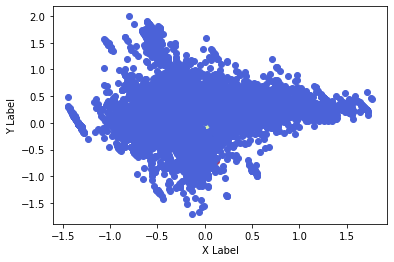

In [0]:
clusters_plot(components_df, K, palette,"component", 2)

1 -> 0
2 -> 1
3 -> 2
4 -> 3
5 -> 4
6 -> 5
7 -> 6
8 -> 7
9 -> 8
10 -> 9
11 -> 10
13 -> 11
13 -> 11
15 -> 12
16 -> 13
17 -> 14
19 -> 15
20 -> 16
21 -> 17
22 -> 18
23 -> 19
24 -> 20
25 -> 21
26 -> 22
27 -> 23
28 -> 24
29 -> 25
30 -> 26
31 -> 27
32 -> 28
33 -> 29
34 -> 30
37 -> 31
39 -> 32
40 -> 33
42 -> 34
43 -> 35
44 -> 36
45 -> 37
46 -> 38
39 -> 32
49 -> 39
50 -> 40
51 -> 41
52 -> 42
42 -> 34
55 -> 43
56 -> 44
57 -> 45
59 -> 46
39 -> 32
61 -> 47
62 -> 48
63 -> 49
64 -> 50
65 -> 51
66 -> 52
42 -> 34
68 -> 53
70 -> 54
68 -> 53
72 -> 55
73 -> 56
75 -> 57
78 -> 58
79 -> 59
80 -> 60
82 -> 61
83 -> 62
84 -> 63
85 -> 64
42 -> 34
3 -> 2
88 -> 65
91 -> 66
92 -> 67
93 -> 68
94 -> 69
95 -> 70
97 -> 71
99 -> 72
100 -> 73
42 -> 34
103 -> 74
104 -> 75
49 -> 39
42 -> 34
107 -> 76
108 -> 77
109 -> 78
110 -> 79
111 -> 80
112 -> 81
113 -> 82
114 -> 83
115 -> 84
117 -> 85
118 -> 86
39 -> 32
39 -> 32
121 -> 87
122 -> 88
123 -> 89
124 -> 90
125 -> 91
126 -> 92
127 -> 93
128 -> 94
129 -> 95
130 -> 96
131 -> 97
132 -> 98
133 -> 99
134 -> 100
135 -> 101
137 -> 102
138 -> 103
139 -> 104
85 -> 64
141 -> 105
142 -> 106
143 -> 107
144 -> 108
145 -> 109
147 -> 110
148 -> 111
149 -> 112
150 -> 113
151 -> 114
152 -> 115
153 -> 116
154 -> 117
155 -> 118
157 -> 119
158 -> 120
159 -> 121
160 -> 122
161 -> 123
162 -> 124
163 -> 125
164 -> 126
165 -> 127
166 -> 128
167 -> 129
168 -> 130
169 -> 131
170 -> 132
172 -> 133
39 -> 32
174 -> 134
175 -> 135
176 -> 136
177 -> 137
39 -> 32
83 -> 62
75 -> 57
182 -> 138
5 -> 4
184 -> 139
185 -> 140
186 -> 141
187 -> 142
188 -> 143
189 -> 144
190 -> 145
191 -> 146
192 -> 147
194 -> 148
195 -> 149
196 -> 150
197 -> 151
198 -> 152
199 -> 153
200 -> 154
201 -> 155
202 -> 156
203 -> 157
204 -> 158
205 -> 159
206 -> 160
207 -> 161
208 -> 162
209 -> 163
210 -> 164
211 -> 165
212 -> 166
213 -> 167
214 -> 168
215 -> 169
30 -> 26
217 -> 170
218 -> 171
219 -> 172
220 -> 173
221 -> 174
222 -> 175
223 -> 176
39 -> 32
225 -> 177
226 -> 178
227 -> 179
228 -> 180
42 -> 34
230 -> 181
231 -> 182
232 -> 183
42 -> 34
234 -> 184
236 -> 185
237 -> 186
238 -> 187
239 -> 188
240 -> 189
241 -> 190
242 -> 191
243 -> 192
244 -> 193
245 -> 194
246 -> 195
247 -> 196
248 -> 197
249 -> 198
250 -> 199
251 -> 200
39 -> 32
254 -> 201
255 -> 202
188 -> 143
257 -> 203
258 -> 204
259 -> 205
260 -> 206
261 -> 207
262 -> 208
263 -> 209
264 -> 210
265 -> 211
266 -> 212
267 -> 213
33 -> 29
269 -> 214
270 -> 215
272 -> 216
83 -> 62
274 -> 217
275 -> 218
85 -> 64
277 -> 219
278 -> 220
279 -> 221
280 -> 222
22 -> 18
282 -> 223
283 -> 224
284 -> 225
39 -> 32
287 -> 226
83 -> 62
289 -> 227
290 -> 228
291 -> 229
292 -> 230
293 -> 231
294 -> 232
85 -> 64
296 -> 233
49 -> 39
85 -> 64
299 -> 234
39 -> 32
301 -> 235
85 -> 64
303 -> 236
305 -> 237
306 -> 238
307 -> 239
49 -> 39
309 -> 240
310 -> 241
129 -> 95
312 -> 242
313 -> 243
314 -> 244
315 -> 245
316 -> 246
317 -> 247
318 -> 248
319 -> 249
83 -> 62
42 -> 34
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -> 250
322 -

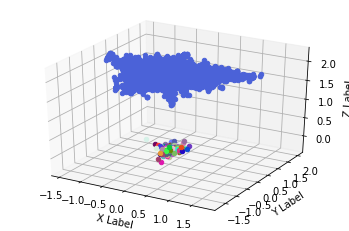

In [0]:
clusters_plot(components_df, K, palette, "component", 3)

####Clusters evaluation

In [0]:
score = evaluate_model(clusters_df, "cluster")

In [0]:
print(score)

0.23542096352531228

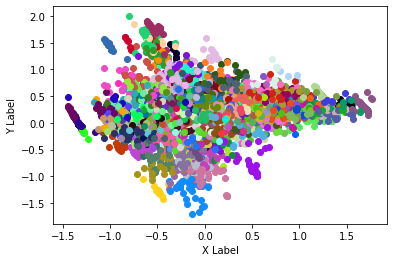

In [0]:
clusters_plot(clusters_df, K, palette,"cluster", 2)

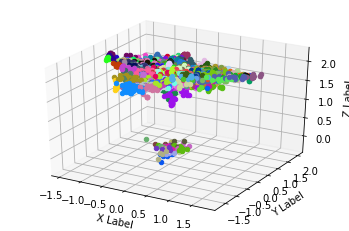

In [0]:
clusters_plot(clusters_df, K, palette,"cluster", 3)

### Some results

In [0]:
import matplotlib.pyplot as plt
size = [500,1000,2000,3000,5000,7000,10000]

#size = [1000,3000,5000,7000,10000,20000]

####Time vs dataframe size

In [0]:
time_graph = [8.82,8.37,15.5,22.09,55.53,75.82, 141.658100537]
time_clust = [0.058,0.064,0.144,1.10,5.70,15.20, 0.3603537170000095]

plt.plot(size, time_graph, 'or-', label='Graph')
plt.plot(size, time_clust, 'ob-', label='Cluster')
plt.legend()
plt.xlabel('# of entries')
plt.ylabel('Seconds')
plt.show()

####Score vs dataframe size

In [0]:
score_graph = [-0.3958,-0.6597,-0.438,-0.4553,-0.4284,-0.4011, 0.7027403280872422]
score_clust = [0.5987,0.3697,0.2217,0.1671,0.1289,0.1206, 0.23542096352531228]

plt.plot(size, score_graph, 'or-', label='Graph')
plt.plot(size, score_clust, 'ob-', label='Cluster')
plt.legend()
plt.xlabel('# of entries')
plt.ylabel('Scores')
plt.show()

#### K vs sataframe size

In [0]:
cc = [3,30,234,833,1525,2394,257]

plt.plot(size, cc, 'og-')
plt.legend()
plt.xlabel('# of entries')
plt.ylabel('K')
plt.show()

##Advanced Cluster

perchè stiamo mostrando questi risultati su 100000000

In [0]:
N_ENTRIES = 1000000

In [0]:
cut_books_df = get_first_entries(cleaned_books_df, N_ENTRIES).cache()

In [0]:
engineered_books_df = engineered_dataframe(cut_books_df)

In [0]:
t_start = process_time()
model, clusters_df = k_means(engineered_books_df, K, max_iter=MAX_ITERATIONS, distance_measure="cosine")
t_end = process_time()
print(f'execution time: {t_end - t_start} secs')

In [0]:
clusters_plot(components_df, K, palette,"component", 2)

In [0]:
clusters_plot(components_df, K, palette,"component", 3)